In [3]:
import copy

import matplotlib.pyplot as plt
import numpy as np
#import mitiq
from mitiq import zne
from qiskit import (IBMQ, ClassicalRegister, QuantumCircuit, QuantumRegister,
                    execute, transpile)
from qiskit import Aer
from qiskit.providers.aer import AerSimulator  , QasmSimulator
from qiskit.quantum_info import Operator
from qiskit.utils.mitigation.fitters import CompleteMeasFitter

from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

from lib import util

#from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_manila'))
backend_real_jakarta = provider.get_backend('ibmq_manila')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_sim_noisy_jakarta

ibmqfactory.load_account:WARNING:2022-11-23 15:50:37,490: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
qubits_measure=[0,1,2,3,4]
qubits=qubits_measure
shots=10000
config=BACKEND.configuration()
N_qubits_backend=config.n_qubits

In [6]:
qr=QuantumRegister(N_qubits_backend,name='q')
qc=QuantumCircuit(qr)

qc.h(qr[0])
qc.cx(qr[0],qr[1])
qc.cx(qr[1],qr[2])
qc.cx(qr[2],qr[3])
qc.cx(qr[3],qr[4])
#qc.h(qr[0])
#qc.measure_all()

qc.draw()

┌───┐                    
q_0: ┤ H ├──■─────────────────
     └───┘┌─┴─┐               
q_1: ─────┤ X ├──■────────────
          └───┘┌─┴─┐          
q_2: ──────────┤ X ├──■───────
               └───┘┌─┴─┐     
q_3: ───────────────┤ X ├──■──
                    └───┘┌─┴─┐
q_4: ────────────────────┤ X ├
                         └───┘

In [7]:
cal_circs_GEM, s_labels = util.GEM_calibration_circuits(qc=qc,qubits_measure=qubits_measure)
cal_circs_GEM[0][0].count_ops()

OrderedDict([('measure', 5), ('cal_1', 1)])

In [8]:
backend=backend_sim_ideal
qr = QuantumRegister(N_qubits_backend)
meas_calibs, state_labels = util.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=[0,1,2,3,4])
print(len(meas_calibs))
job_cal = execute(meas_calibs, backend=backend, shots=shots)
#job_cal.queue_position(refresh=True)
cal_results = job_cal.result()
cal_counts=cal_results.get_counts()
print(cal_counts)
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
#print(meas_fitter.cal_matrix())

32
[{'00000': 10000}, {'00001': 10000}, {'00010': 10000}, {'00011': 10000}, {'00100': 10000}, {'00101': 10000}, {'00110': 10000}, {'00111': 10000}, {'01000': 10000}, {'01001': 10000}, {'01010': 10000}, {'01011': 10000}, {'01100': 10000}, {'01101': 10000}, {'01110': 10000}, {'01111': 10000}, {'10000': 10000}, {'10001': 10000}, {'10010': 10000}, {'10011': 10000}, {'10100': 10000}, {'10101': 10000}, {'10110': 10000}, {'10111': 10000}, {'11000': 10000}, {'11001': 10000}, {'11010': 10000}, {'11011': 10000}, {'11100': 10000}, {'11101': 10000}, {'11110': 10000}, {'11111': 10000}]


In [9]:
def circs_run(circs,qcirc,backend=BACKEND,qubits=qubits,qubits_measure=qubits_measure):
    config=backend.configuration()
    N_qubits_backend=config.n_qubits

    qr=QuantumRegister(N_qubits_backend,name='q')
    qc=QuantumCircuit(qr)

    qc.append(qcirc,qr)
    qc=transpile(qc,backend,optimization_level=0)

    cal_circs_meas, s_labels = util.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=qubits_measure)
    cal_circs_GEM, s_labels = util.GEM_calibration_circuits(qc=qc,qubits_measure=qubits_measure)
    circs += cal_circs_meas
    print(len(cal_circs_meas))
    circs += cal_circs_GEM[0]
    print(cal_circs_GEM[0][0].count_ops())
    print(len(cal_circs_GEM[0]))
    circs += cal_circs_GEM[1]
    print(len(cal_circs_GEM[1]))
    print(cal_circs_GEM[1][0].count_ops())
    qc.measure_all()
    qc=transpile(qc,backend=BACKEND,optimization_level=0)
    circs.append(qc)

    

    return circs,s_labels


In [10]:
circs=[]
circs,s_labels=circs_run(circs,qc)
print(len(circs))
job=execute(circs,BACKEND,shots=shots,optimization_level=0)
job_result=job.result()
job_counts=job_result.get_counts()
job_qiskit=copy.deepcopy(cal_results)
job_GEM_L=copy.deepcopy(cal_results)
job_GEM_R=copy.deepcopy(cal_results)
for j in range (0,len(s_labels)):
    job_qiskit.results[j].data.counts=job_counts[j]
meas_fitter=CompleteMeasFitter(job_qiskit,s_labels)
C_qiskit=meas_fitter.cal_matrix
for j in range (0,len(s_labels)):
    job_GEM_L.results[j].data.counts=meas_fitter.filter.apply(job_counts[j+len(s_labels)],method="least_squares")
    job_GEM_R.results[j].data.counts=meas_fitter.filter.apply(job_counts[j+2*len(s_labels)],method="least_squares")

meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L, state_labels=s_labels)
meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R, state_labels=s_labels)
Cal_GEM_L = meas_fitter_GEM_L.cal_matrix
Cal_GEM_R = meas_fitter_GEM_R.cal_matrix
C=(Cal_GEM_L+Cal_GEM_R)/2
    
    #define the equilibrium counts distribution
rand_vec_prob=np.sum(C,axis=1,dtype='float')/(len(s_labels))
    
    
    #calculate the probaabilities of dep error
p_t=(C[0][0]-1)/(rand_vec_prob[0]-1)
print('p_t')
print(p_t)

    #define the random prob vector and equilibrium prob vector
print('rand_vec')
print(rand_vec_prob)
rand_vec=p_t*shots*rand_vec_prob

D=np.zeros((len(s_labels),len(s_labels)))

for k in range (0,len(s_labels)):
    for j in range (0,len(s_labels)):
        D[k][j]=(C[k][j]-p_t*rand_vec_prob[k])/(1-p_t)
CGP=D
    
    
meas_fitter_GP=copy.deepcopy(meas_fitter)
meas_fitter_GP.cal_matrices=CGP

meas_fitter_GEM=copy.deepcopy(meas_fitter)
meas_fitter_GEM.cal_matrices=C



32
OrderedDict([('measure', 5), ('cal_1', 1)])
32
32
OrderedDict([('measure', 5), ('cal_2', 1)])
97
p_t
0.014696564707393436
rand_vec
[0.03158588 0.03157759 0.03120696 0.03133544 0.03120697 0.03109726
 0.0310188  0.03126444 0.03131296 0.03153155 0.0312577  0.03110345
 0.03128893 0.03106486 0.03129273 0.03123354 0.03144814 0.03152282
 0.03115852 0.031322   0.03096333 0.03141315 0.03138994 0.03097504
 0.03120687 0.03127562 0.031237   0.03141927 0.03111019 0.03111928
 0.03094707 0.0311127 ]


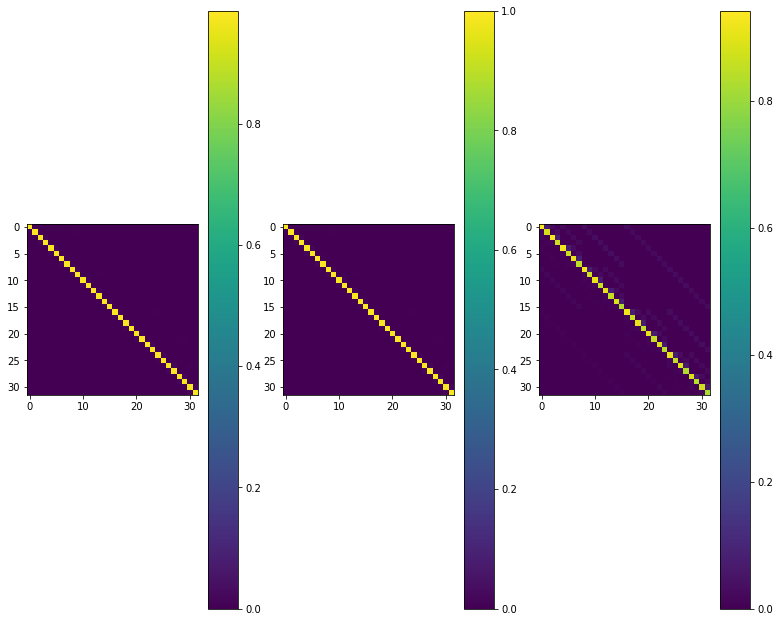

In [11]:
plt.figure(figsize=(13,11))
plt.subplot(131)
plt.imshow(C)
plt.colorbar()
plt.subplot(132)
plt.imshow(D)
plt.colorbar()
plt.subplot(133)
plt.imshow(C_qiskit)
plt.colorbar()
plt.show()

In [12]:
job_counts_circ_raw=job_counts[-1]
raw_vector=util.occurrences_to_vector(job_counts_circ_raw)
new_vector_CGP=(raw_vector-rand_vec)/(1-p_t)
new_counts=dict(zip(s_labels,new_vector_CGP))
job_counts_circ_CGP=meas_fitter_GP.filter.apply(new_counts,method="least_squares")
job_counts_circ_qiskit=meas_fitter.filter.apply(job_counts[-1],method="least_squares")
job_counts_circ_GEM=meas_fitter_GEM.filter.apply(job_counts_circ_qiskit,method="least_squares")

In [13]:
qr=QuantumRegister(N_qubits_backend)
qc=QuantumCircuit(qr)

qc.h(qr[0])
qc.cx(qr[0],qr[1])
qc.cx(qr[1],qr[2])
qc.cx(qr[2],qr[3])
qc.cx(qr[3],qr[4])

qc.measure_all()
circuit =  qc
    # Convert from raw measurement counts to the expectation value
scale_factors = [1., 2., 3.]
folded_circuits = [
     zne.scaling.fold_all(circuit, scale)
        for scale in scale_factors
]
job_zne = execute(
    experiments=folded_circuits,
    backend=BACKEND,
    optimization_level=0,  # Important to preserve folded gates.
    shots=shots,
)
    # Check that the circuit depth is (approximately) scaled as expected
#print(a)
for j, c in enumerate(folded_circuits):
    print(f"Number of gates of folded circuit {j} scaled by: {len(c) / len(circuit):.3f}")
counts_zne=np.zeros(len(s_labels))
all_counts = [job_zne.result().get_counts(i) for i in range(len(folded_circuits))]
z=np.zeros(len(s_labels))
for i in range (0,len(s_labels)):
    string=s_labels[i]
    expectation_values=[]
    for counts in all_counts:
        if string in counts:
            expectation_values.append(counts[string] / shots)
        else:
            expectation_values.append(0)
    z[i] = zne.RichardsonFactory.extrapolate(scale_factors, expectation_values)*shots

new_counts_zne=dict(zip(util.bin_list(5),z))


Number of gates of folded circuit 0 scaled by: 0.909
Number of gates of folded circuit 1 scaled by: 0.909
Number of gates of folded circuit 2 scaled by: 1.818


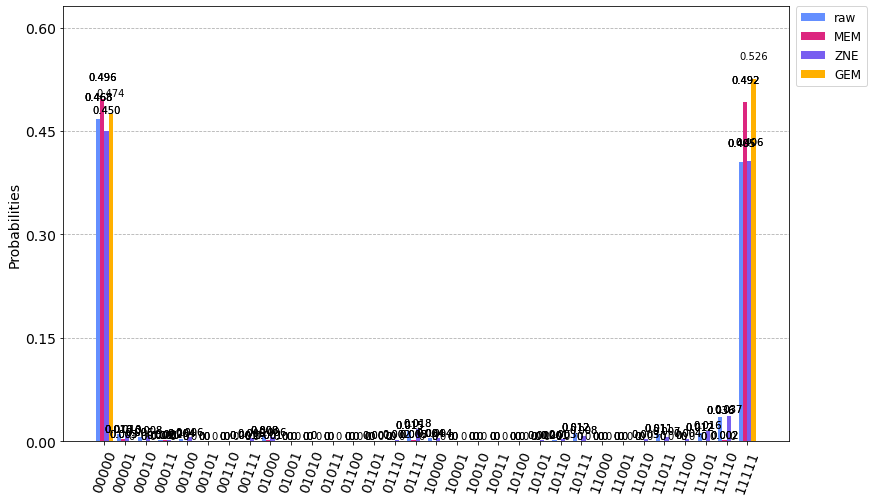

In [14]:
legend = ['raw', 'MEM','ZNE','GEM']#,'CGP','ZNE']
plot_histogram([job_counts_circ_raw, job_counts_circ_qiskit,new_counts_zne,job_counts_circ_GEM],legend=legend,figsize=(13,8))#,job_counts_circ_CGP,new_counts_zne], legend=legend,figsize=(13,8))